In [1]:
import os
import pylab as pl
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import import_ipynb
from scipy import optimize

In [2]:
def read_log_file_temperature(directory, filename):
    lines = open(os.path.join(directory, filename)).readlines()
    time = [datetime.datetime.strptime(i[0:17], '%Y%m%d,%H:%M:%S') for i in lines]
    temp_cold = [float((i[-6:-1])) for i in lines]
    temp_hot = [float((i[-12:-7])) for i in lines]
    return temp_hot, temp_cold, time

In [3]:
temp_hot, temp_cold, time = read_log_file_temperature('/Users/micol/Documents/Imperial/Year4/Master_Project/bruker_logs', 'thursday2-20180927113645.log')

In [4]:
zero_time = time[0].second+time[0].minute*60+time[0].hour*3600
time_sec = [time[i].second+time[i].minute*60+time[i].hour*3600 - zero_time for i in range(len(time))]

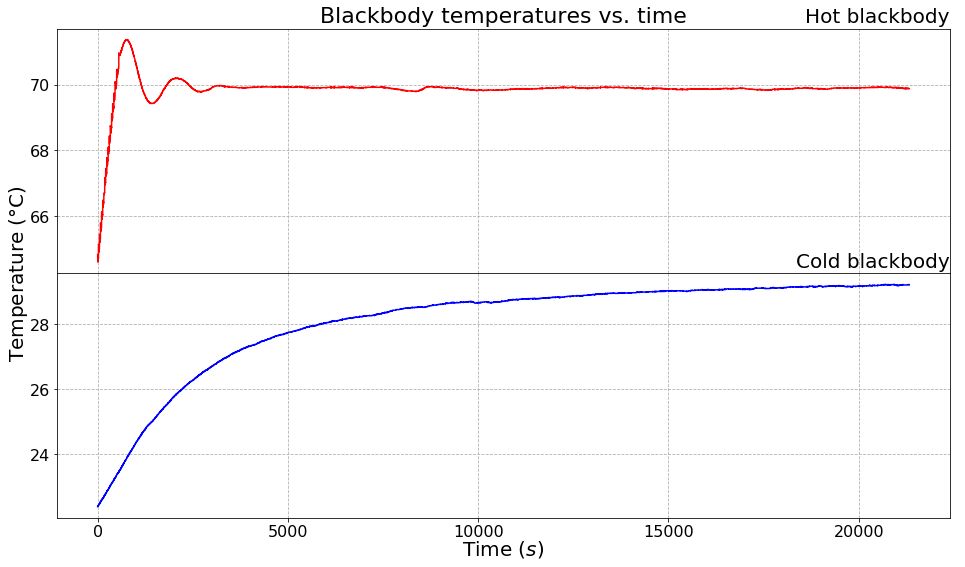

In [5]:
fig = plt.figure(figsize=(16,9))

ax = fig.add_subplot(111)    # The big subplot
ax.set_xlabel('Time ($s$)',fontsize=20)
ax.set_ylabel('Temperature ($\degree$C)', fontsize=20)
# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_title('Blackbody temperatures vs. time', fontsize=22)

ax1 = fig.add_subplot(211)
plt.grid(linestyle='--')
plt.plot(time_sec, temp_hot, 'r')
ax1.set_title('Hot blackbody', fontsize=20, loc='right')
ax1.tick_params(labelsize=16, labelcolor='black')

ax2 = fig.add_subplot(212)
plt.grid(linestyle='--')
plt.plot(time_sec,temp_cold, 'b')
ax2.set_title('Cold blackbody', fontsize=20, loc='right')
ax2.tick_params(labelsize=16, labelcolor='black')

fig.subplots_adjust(hspace=0.) #remove space between subplots
fig.savefig('Temperature_log.png', dpi=600)

In [6]:
def thermal_func(time, T1, T2, tau): # tau is time taken for it to reach 63% of its final temperature
    return (T2-T1)*(1-np.exp(-time/tau))+T1

params, cov = optimize.curve_fit(thermal_func, time_sec, temp_cold)

print(('Initial temperature is {} C').format(params[0]))
print(('Final temperature is {} C').format(params[1]))
print(('Time constant is {}s which is approx. {} minutes').format(params[2], params[2]/60))

Initial temperature is 22.545542009155543 C
Final temperature is 29.074210606512672 C
Time constant is 3128.3332326353193s which is approx. 52.138887210588656 minutes


In [21]:
# if the measurements were turned on after the instrument had been on for a long time, then T1 could have significant errors

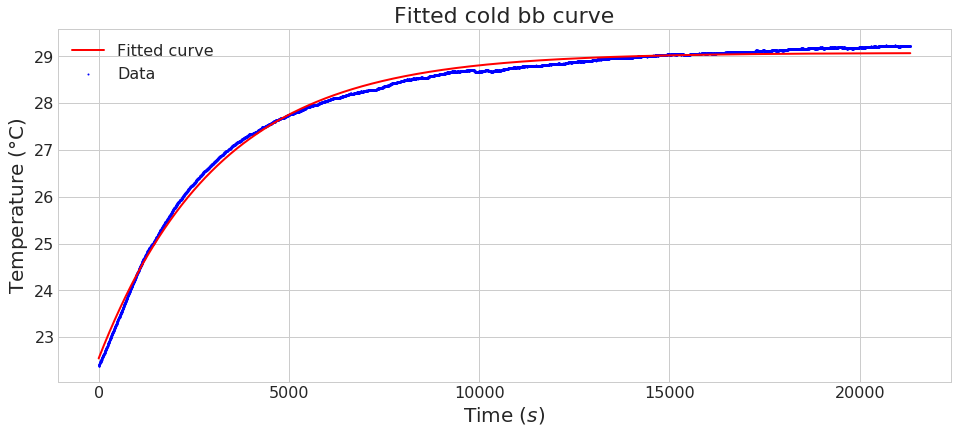

In [27]:
# Visualise the fit
plt.figure(figsize=(16, 6.5))
plt.scatter(time_sec, temp_cold, label='Data', s=1, color='blue')
plt.plot(time_sec, thermal_func(np.array(time_sec), *params), label='Fitted curve', color='red')
plt.title('Fitted cold bb curve', fontsize=22)
plt.legend(loc='best', fontsize=16)
plt.tick_params(labelsize=16)
plt.xlabel('Time ($s$)', fontsize=20)
plt.ylabel('Temperature ($\degree$C)', fontsize=20)
plt.grid(b=True)
plt.show()

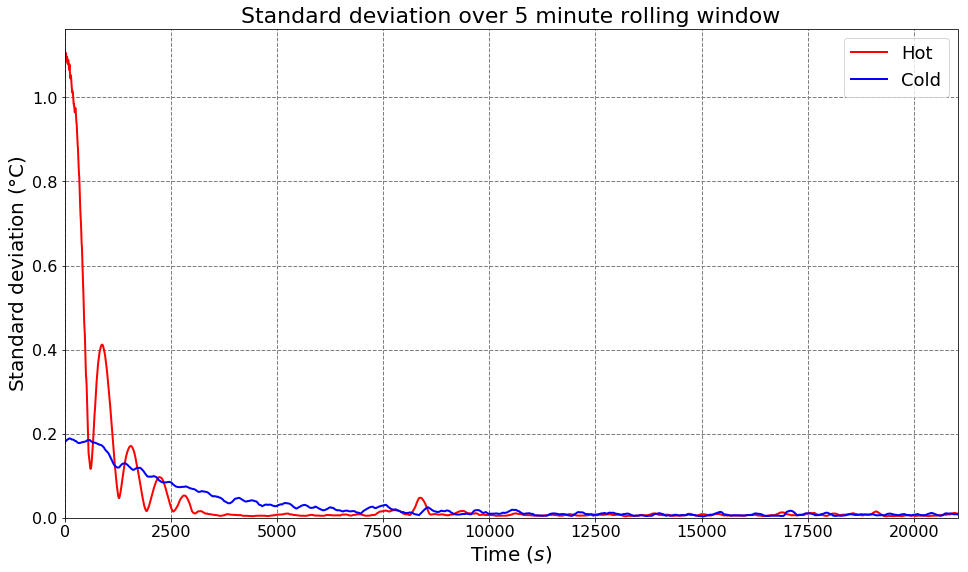

In [8]:
fig = plt.figure(figsize=(16,9))

rolls_H = [np.std(temp_hot[i:i+150]) for i in range(0, len(temp_hot)-150)]
plt.plot(time_sec[0:-150], rolls_H, 'r', linewidth=2)

rolls_C = [np.std(temp_cold[i:i+150]) for i in range(0, len(temp_cold)-150)]
plt.plot(time_sec[0:-150], rolls_C, 'b', linewidth=2)

plt.title('Standard deviation over 5 minute rolling window', fontsize=22)
plt.xlabel('Time ($s$)', fontsize=20, color = 'black')
plt.ylabel('Standard deviation ($\degree$C)', fontsize=20, color = 'black')
plt.xlim(0, time_sec[-150])
plt.ylim(0)
plt.tick_params(labelsize=16)
plt.grid(color='grey', linestyle='--', linewidth=1)
plt.legend(['Hot', 'Cold'], fontsize=18, frameon=True)

fig.savefig('Standard_deviation_both.png', dpi=600)

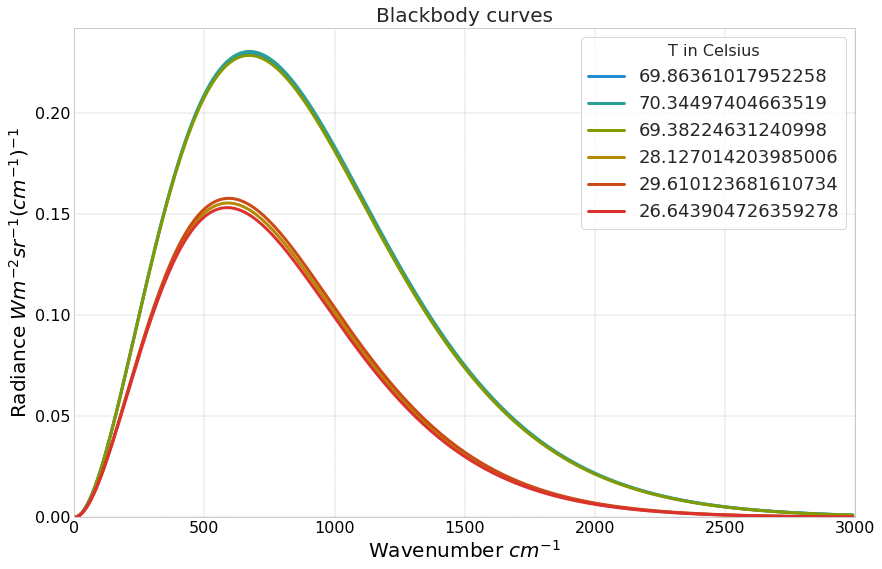

In [17]:
#note the analysis below is over the whole data set; not just over 5 minutes!
from Blackbody_curves import wavenumber_max, wavenumber_min, step, h, c, k, a, e, planck, plot_planck

hot_mean = np.mean(temp_hot)
hot_std = np.std(temp_hot)

cold_mean = np.mean(temp_cold)
cold_std = np.std(temp_cold)

plot_planck([hot_mean, hot_mean+hot_std, hot_mean-hot_std, cold_mean, cold_mean+cold_std, cold_mean-cold_std])

In [10]:
# Now calculate radiance uncertainty as function of time and wavenumber (5 minute windows) for the two blackbodies
# Do this by taking difference of radiances corresponding to +1std and mean
# Note this is only an approximation

wavenums = []
times = []
deltas = []

roll_mean_C = [np.mean(temp_cold[i:i+150]) for i in range(0, len(temp_cold)-150)]

for i, s, t in zip(roll_mean_C, rolls_C, time_sec[0:-150]):
    for w in np.arange(wavenumber_min, wavenumber_max, step):
        delta_rad = planck(w, i+s+273.15) - planck(w, i+273.15)
        deltas.append(delta_rad)
        wavenums.append(w)
        times.append(t)      

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

def plot_deltas(start, stop, azimuth=None, elevation=None): #start and stop is roughly the time in seconds
    scaling = int(np.floor(len(times)/time_sec[-1]))
    fig = plt.figure(figsize=(16,9))
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(times[start*scaling:stop*scaling], [x/100 for x in wavenums[start*scaling:stop*scaling]], [x*100 for x in deltas[start*scaling:stop*scaling]], s=1, c=np.arange(len(times[start*scaling:stop*scaling])), cmap='inferno')
    ax.tick_params(labelsize=12, labelcolor='grey')

    ax.set_xlabel('Time (s)', color='grey', labelpad=15)
    ax.set_ylabel(r'Wavenumber $cm^{-1}$', color='grey', labelpad=15)
    ax.set_zlabel(r'Radiance uncertainty $W m^{-2} sr^{-1} (cm^{-1})^{-1}$', color='grey', labelpad=15)
    ax.view_init(azim=azimuth, elev=elevation)

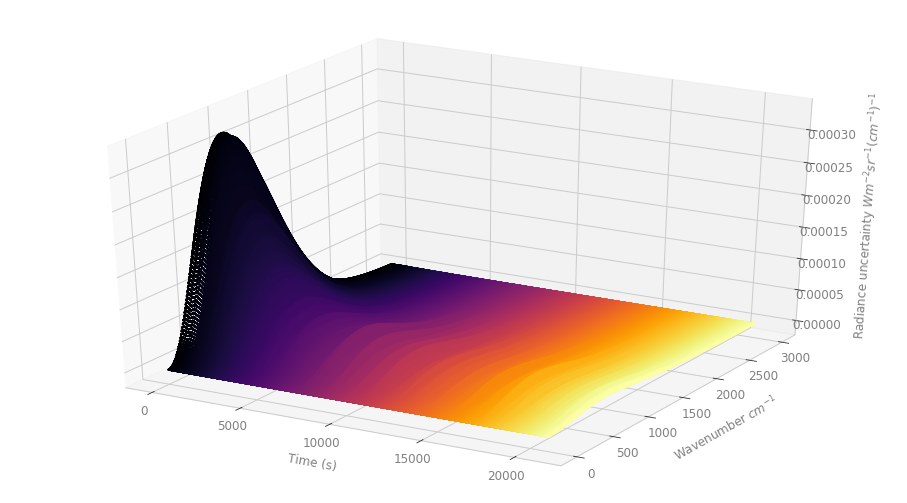

In [12]:
plot_deltas(0, time_sec[-1]) #standard deviation!!!!!

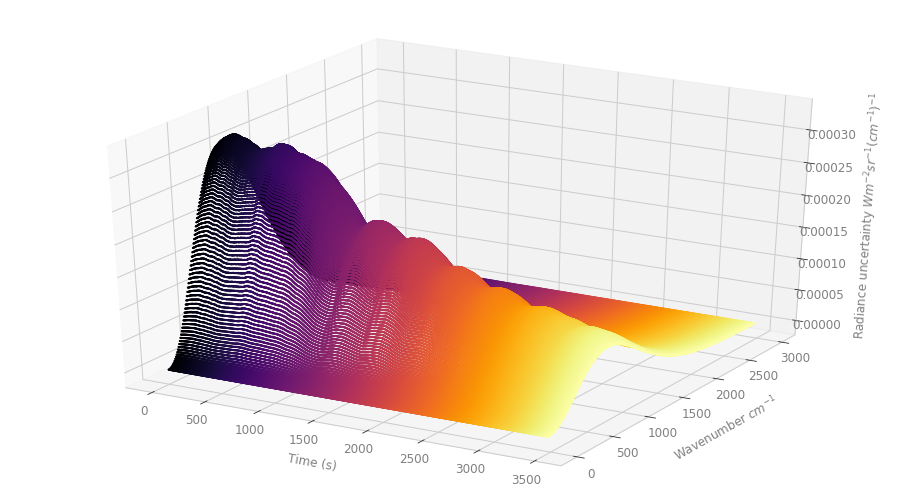

In [13]:
plot_deltas(0, 3500)

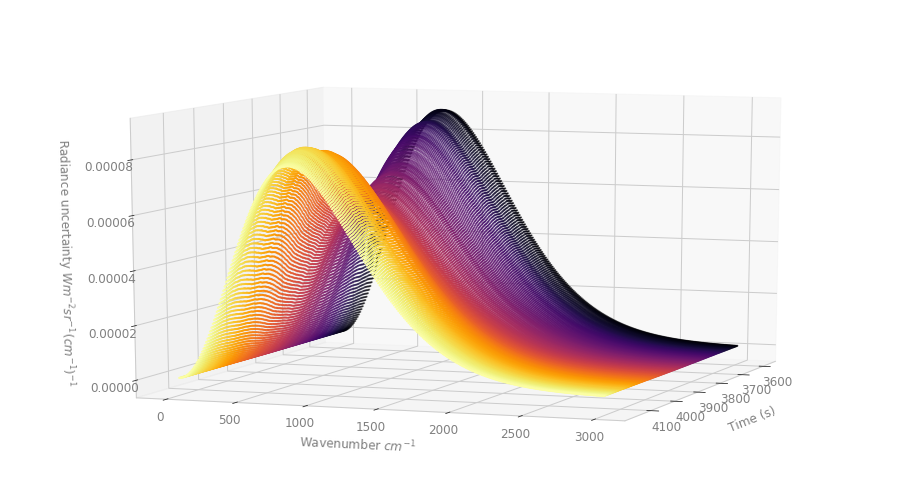

In [14]:
plot_deltas(3600, 4200, 20, 10)

In [18]:
wavenums = []
times = []
deltas = []

roll_mean_H = [np.mean(temp_hot[i:i+150]) for i in range(0, len(temp_hot)-150)]

for i, s, t in zip(roll_mean_H, rolls_H, time_sec[0:-150]):
    for w in np.arange(wavenumber_min, wavenumber_max, step):
        delta_rad = planck(w, i+s+273.15) - planck(w, i+273.15)
        deltas.append(delta_rad)
        wavenums.append(w)
        times.append(t)  

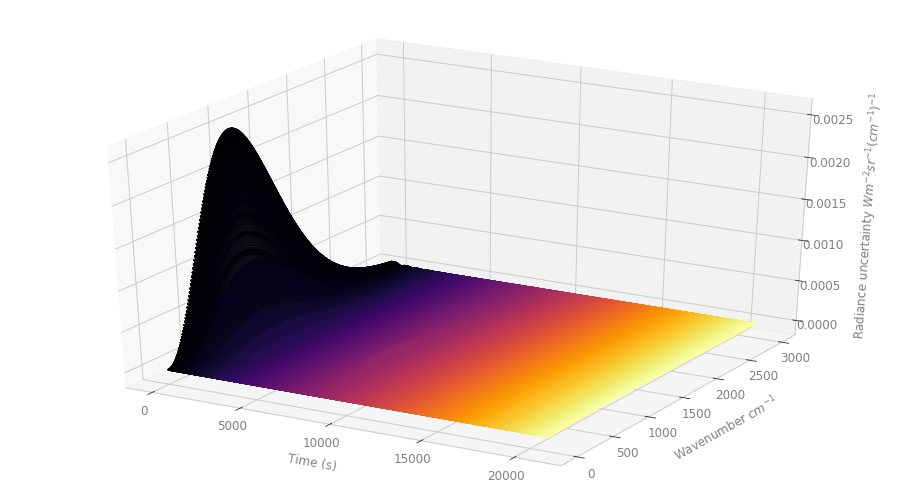

In [20]:
plot_deltas(0, time_sec[-1])

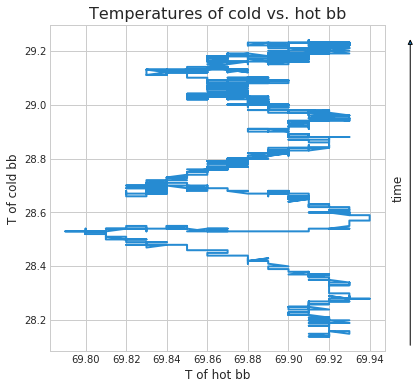

In [15]:
# this is just to see whether they always rise together or not, in fact the graph shows that sometimes one rises and the other drops
plt.figure(figsize=(6,6))
plt.plot(temp_hot[3000:-1], temp_cold[3000:-1])
plt.title('Temperatures of cold vs. hot bb')
plt.xlabel('T of hot bb')
plt.ylabel('T of cold bb')
plt.text(1.02, 0.5, 'time', {'fontsize': 12},
         horizontalalignment='left',
         verticalalignment='center',
         rotation=90,
         clip_on=False,
         transform=plt.gca().transAxes)
plt.annotate('', (69.96,29.25), xytext=(69.96,28.1), xycoords='data', arrowprops=dict(arrowstyle="-|>"), annotation_clip=False)
plt.show()

the plot shows that the two temperatures are sometimes positively and sometimes negatively correlated

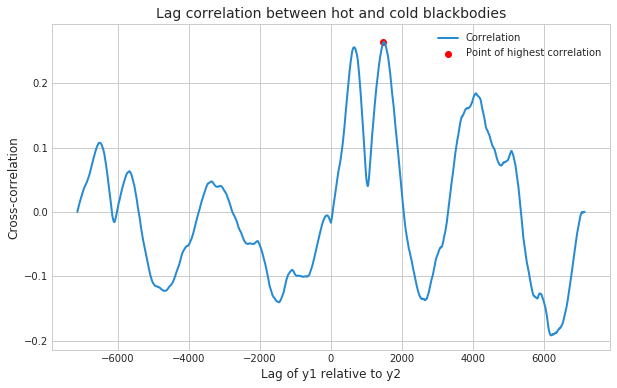

max correlation is at lag 1473 which is approx 52 minutes


In [16]:
# Temperature time series lag correlation

new_temp_hot = temp_hot[3000:-1] #define data window in which we want to analyse the correlation
new_temp_cold = temp_cold[3000:-1]

lags = np.arange(-len(new_temp_hot) + 1, len(new_temp_hot))
# calculate cross covariance and cross correlation as defined in standard text books:
ccov = np.correlate(new_temp_hot - np.mean(new_temp_hot), new_temp_cold - np.mean(new_temp_cold), mode='full') #full means all points where the two functions overlap are used. Therefore boundary effects are visible
ccor = ccov / (len(new_temp_hot) * np.std(new_temp_hot) * np.std(new_temp_cold))

plt.figure(figsize=(10,6))
plt.plot(lags, ccor)

plt.title('Lag correlation between hot and cold blackbodies', fontsize=14)
plt.ylabel('Cross-correlation')
plt.xlabel('Lag of y1 relative to y2')

maxlag = lags[np.argmax(ccor)]
plt.scatter(maxlag, np.max(ccor), color ='r')
plt.legend(['Correlation', 'Point of highest correlation'])

plt.show()
print(("max correlation is at lag {} which is approx {} minutes").format(maxlag, str(np.round(maxlag*2.1/60, decimals=0)).split('.')[0]))

It is interesting to note that sometimes the hot bb lags the cold bb

**Question**

How can we distinguish between a common factor eg room temperature or spectrometer heating up causing both temperatures to rise, and the hot causing the cold to rise? In the first case, any correlation would not be significant. Should we do correlation wrt second derivative of time?

**ToDo**

rate of change of instrument response function??

significance test on lag - statistical test
need to know room temperature - jon should have the measurements - he doesnt . Multiple linear regression
how i ttranslates into uncrtainty in emissivity